In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import praw

In [21]:
# we use this function to convert responses to dataframes
def df_from_response(res):
    # initialize temp dataframe for batch of data in response
    df = pd.DataFrame()

    # loop through each post pulled from res and append to df
    for post in res.json()['data']['children']:
        df = df.append({
            'subreddit': post['data']['subreddit'],
            'title': post['data']['title'],
            'selftext': post['data']['selftext'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score'],
            'total_awards_received': post['data']['total_awards_received'],
            'num_comments' : post['data']['num_comments'],
            'link_flair_css_class': post['data']['link_flair_css_class'],
            'created_utc': datetime.fromtimestamp(post['data']['created_utc']).strftime('%Y-%m-%dT%H:%M:%SZ'),
            'id': post['data']['id'],
            'kind': post['kind']
        }, ignore_index=True)

    return df

# authenticate API
client_auth = requests.auth.HTTPBasicAuth('ARq9LWzcl8vmUQ', 'tIyiaaYR_tCUQ_5Vy9XI0bM6N1mj_w')
pw = open('pw.txt', 'r')
data = {'grant_type': 'password',
        'username': 'PGCdev',
        'password': pw}

headers = {'User-Agent': 'myBot/0.0.1'}

# send authentication request for OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=client_auth, data=data, headers=headers)
# extract token from response and format correctly
token = f"bearer {res.json()['access_token']}"
# update API headers with authorization (bearer token)
headers = {**headers, **{'Authorization': token}}

# initialize dataframe and parameters for pulling data in loop
data = pd.DataFrame()
params = {'limit': 100}

# loop through 10 times (returning 1K posts)
for i in range(3):
    # make request
    res = requests.get("https://oauth.reddit.com/r/news",
                       headers=headers,
                       params=params)

    # get dataframe from response
    new_df = df_from_response(res)
    # take the final row (oldest entry)
    row = new_df.iloc[len(new_df)-1]
    # create fullname
    fullname = row['kind'] + '_' + row['id']
    # add/update fullname in params
    params['after'] = fullname
    
    # append new_df to data
    data = data.append(new_df, ignore_index=True)

In [4]:
data.describe()

,downs,num_comments,score,total_awards_received,ups,upvote_ratio
count,266.0,266.000000,266.000000,266.000000,266.000000,266.000000
mean,0.0,505.342105,5038.379699,3.729323,5038.379699,0.881805
std,0.0,1429.266815,14565.897985,15.058692,14565.897985,0.068640
min,0.0,0.000000,2.000000,0.000000,2.000000,0.590000
25%,0.0,27.000000,122.000000,0.000000,122.000000,0.840000
50%,0.0,83.500000,324.000000,0.000000,324.000000,0.900000
75%,0.0,280.250000,1749.000000,1.000000,1749.000000,0.940000
max,0.0,14214.000000,95376.000000,147.000000,95376.000000,0.980000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   created_utc            266 non-null    object 
 1   downs                  266 non-null    float64
 2   id                     266 non-null    object 
 3   kind                   266 non-null    object 
 4   link_flair_css_class   2 non-null      object 
 5   num_comments           266 non-null    float64
 6   score                  266 non-null    float64
 7   selftext               266 non-null    object 
 8   subreddit              266 non-null    object 
 9   title                  266 non-null    object 
 10  total_awards_received  266 non-null    float64
 11  ups                    266 non-null    float64
 12  upvote_ratio           266 non-null    float64
dtypes: float64(6), object(7)
memory usage: 27.1+ KB


In [6]:
data[data.score == data.score.max()]

,created_utc,downs,id,kind,link_flair_css_class,num_comments,score,selftext,subreddit,title,total_awards_received,ups,upvote_ratio
185,2021-05-14T09:29:09Z,0.0,nccpl2,t3,None,7757.0,95376.0,,news,Black homeowner had a white friend stand in fo...,85.0,95376.0,0.69


In [7]:
data[data.score == data.score.min()]

,created_utc,downs,id,kind,link_flair_css_class,num_comments,score,selftext,subreddit,title,total_awards_received,ups,upvote_ratio
77,2021-05-18T16:56:43Z,0.0,nfq8f7,t3,None,1.0,2.0,,news,North Las Vegas Mayor John Lee says he's posit...,0.0,2.0,0.75


<AxesSubplot:xlabel='ups', ylabel='Count'>

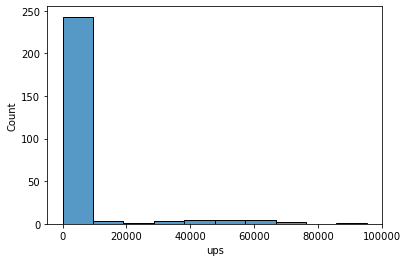

In [8]:
# Ups as measure of viral-ness, ups = popularity/sharing/etc
# Do downs kill a story? Looks like it

sns.histplot(data['ups'], bins = 10)

In [9]:
data['created_utc'].min()

'2021-05-13T07:26:17Z'

<AxesSubplot:xlabel='num_comments', ylabel='Count'>

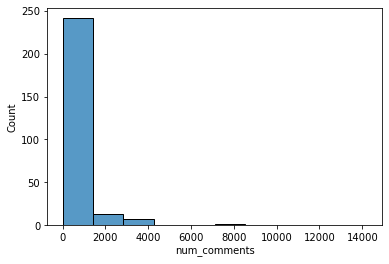

In [10]:
# Comments as measure of viral-ness, comments = engagement, free of the positive/negative issue

sns.histplot(data['num_comments'], bins = 10)

<AxesSubplot:xlabel='num_comments', ylabel='ups'>

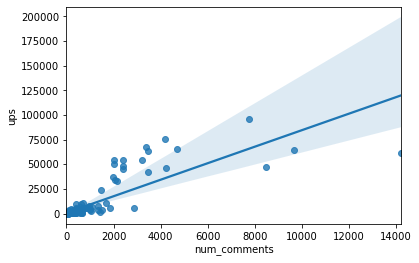

In [11]:
sns.regplot(x=data['num_comments'], y=data['ups'])

In [12]:
data.loc[data['ups'].idxmax()]

created_utc                                           2021-05-14T09:29:09Z
downs                                                                  0.0
id                                                                  nccpl2
kind                                                                    t3
link_flair_css_class                                                  None
num_comments                                                        7757.0
score                                                              95376.0
selftext                                                                  
subreddit                                                             news
title                    Black homeowner had a white friend stand in fo...
total_awards_received                                                 85.0
ups                                                                95376.0
upvote_ratio                                                          0.69
Name: 185, dtype: object

In [13]:
data.loc[data['num_comments'].idxmax()]

created_utc                                           2021-05-13T11:21:28Z
downs                                                                  0.0
id                                                                  nbnfzc
kind                                                                    t3
link_flair_css_class                                                  None
num_comments                                                       14214.0
score                                                              61848.0
selftext                                                                  
subreddit                                                             news
title                    Vaccinated Americans now may go without masks ...
total_awards_received                                                147.0
ups                                                                61848.0
upvote_ratio                                                          0.85
Name: 237, dtype: object

In [30]:
r_news = []
reddit = praw.Reddit(client_id="f8vF2obIPTQn-A", 
                     client_secret="cgTpkIVRjiqt0ov0sne5YMg5v6TxhA", 
                     password=pw, 
                     user_agent="headliner", 
                     username="PGCdev")
news_subreddit = reddit.subreddit('news')
for post in news_subreddit.top(time_filter='all',limit=3000):
    r_news.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, 
                              post.selftext, post.created])
r_news = pd.DataFrame(r_news,columns=['title', 'score', 'id', 'subreddit', 'url', 
                                                            'num_comments', 'body', 'created'])
r_news['title'].head()

OAuthException: invalid_grant error processing request